In this example we fit a very simple convolutional neural network to classify 6 visual object categories (i.e. faces, bodies, houses, etc.) from one another given neural data. 

# Define model and data loaders

In [7]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
print("pytorch version: " + torch.__version__)
print("numpy version: " + np.__version__)

pytorch version: 1.2.0
numpy version: 1.18.5


In [2]:
class Dataset(): # define custom dataset methods
    def __init__(self, data, labels):
        self.data = data
        self.label = labels
        self.mu = torch.mean(data,0)
        self.std = torch.std(data,0)

    def __getitem__(self, index): 
        x = self.data[index,:,:]
        x = (x - self.mu) / self.std # z-score incoming samples
        y = self.label[index].long()
        return x, y

    def __len__(self):
        return self.data.shape[0]

def create_dataset(window_size, val_pct = .2):
    y = torch.randint(6,(480,)).float() # random labels
    data = np.zeros((len(y),20,550)) # simulated data (trials * EEG channels * timepoints)
    for trial in range(len(y)): # generate artificial timeseries with class separation
        data[trial,] = np.random.normal(y[trial],1,(20,550)) # mean of signal defined by class, std = 1
    ds = Dataset(torch.Tensor(data),torch.Tensor(y))
    [trn,val,tst] = torch.utils.data.random_split(ds, [int(np.round(len(ds)*(1-val_pct))),
                                                       int(np.round(len(ds)*val_pct/2)),
                                                       int(np.round(len(ds)*val_pct/2))]) # cross validation split
    return trn, val, tst
    
def create_loader(window_size, bs):
    trn_ds, val_ds, tst_ds = create_dataset(window_size)
    trn_dl = torch.utils.data.DataLoader(trn_ds, batch_size = bs, shuffle = True)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size = bs, shuffle = False)
    tst_dl = torch.utils.data.DataLoader(tst_ds, batch_size = bs, shuffle = False)
    return trn_dl, val_dl, tst_dl

class convNet(nn.Module):
    def __init__(self, hidden_no, window_size, input_chans, kernel_size):
        super(convNet, self).__init__()
        self.hidden_no = hidden_no
        self.conv1 = nn.Conv1d(input_chans, hidden_no, kernel_size=kernel_size,groups=input_chans)
        self.mp1 = nn.MaxPool1d(kernel_size=50,stride=1,padding=0) # max pooling over convolutional filters
        self.fc1 = nn.Linear(hidden_no*(window_size-2*49),6) # 49 is calculated based on kernel size of previous layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.mp1(x)
        x = x.view(x.shape[0],x.shape[1]*x.shape[2])
        x = torch.relu(self.fc1(x.squeeze()))
        return x

# Run main training loop

In [3]:
# Here is a list of hyperparameters that could be optimized
window_size = 550 # number of time points in trial
hidden_no = 20 # number of hidden units in each later
bs = 100 # batch size
num_epochs = 100 # maximum number of training epochs
patience = 10 # how long to wait after performance stagnates before early stopping
cuda_status = 0 # use GPU acceleration if available
num_classes = 6 # number of visual object categories to classify over, chance is NEAR 1/6
input_chans = 20 # number of EEG channels
kernel_size = window_size//11 # size of convolutional kernel (across time)
np.random.seed(21)

if torch.cuda.is_available():
    print('Using GPU to accelerate training.')
    cuda_status = 0
    gpu = torch.device('cuda')

trn_dl, val_dl, tst_dl = create_loader(window_size, bs) # make data set loader

mdl = convNet(hidden_no, window_size, input_chans, kernel_size) # define convolutional neural network
if cuda_status:
    mdl.to(gpu)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(mdl.parameters(), lr=1e-3) # lr = 1e-1 for sliding net, 1e-4 for convnet
reg_lambda = .1

trn_acc = np.zeros((num_epochs,))
val_acc = np.zeros((num_epochs,))
trn_loss = np.zeros((num_epochs,))
val_loss = np.zeros((num_epochs,))
rt = np.zeros((num_epochs,))

keepgoing = 1
epoch = 0
while keepgoing: 
    running_loss = 0
    running_val_loss = 0
    all_trn_pred = []
    all_trn_true = []
    for batch in trn_dl: # main training loop
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        if cuda_status:
            inputs = inputs.to(gpu)
            labels = labels.to(gpu)
        labels.view(-1)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mdl(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        all_trn_pred = np.concatenate((all_trn_pred, np.argmax(outputs.cpu().detach().numpy(),1)),0)
        all_trn_true = np.concatenate((all_trn_true, labels.cpu().detach().numpy()),0)
        
    all_val_pred = []
    all_val_true = []
    for batch in val_dl: # validation loop to see if learning is still progressing
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        if cuda_status:
            inputs = inputs.to(gpu)
            labels = labels.to(gpu)
        # forward
        outputs = mdl(inputs)
        v_loss = criterion(outputs, labels)

        # print statistics
        running_val_loss += v_loss.item()
        all_val_pred = np.concatenate((all_val_pred,np.argmax(outputs.cpu().detach().numpy(),1)),0)
        all_val_true = np.concatenate((all_val_true, labels.cpu().detach().numpy()),0)
    trn_loss[epoch] = running_loss / len(all_trn_true)
    val_loss[epoch] = running_val_loss / len(all_val_true)  
    trn_acc[epoch] = np.mean(all_trn_true == all_trn_pred)
    val_acc[epoch] = np.mean(all_val_true == all_val_pred)
     
    print('Training Epoch: {0}, Training Accuracy: {1:.2f}, Validation Accuracy: {2:.2f}' \
          .format(epoch, trn_acc[epoch], val_acc[epoch]))
    
    if epoch > patience:
        if np.min(val_loss[epoch-patience:epoch + 1]) != np.min(val_loss[0:epoch + 1]):
            keepgoing = 0
    if epoch == num_epochs - 1:
        keepgoing = 0
    epoch += 1

Using GPU to accelerate training.
Training Epoch: 0, Training Accuracy: 0.18, Validation Accuracy: 0.27
Training Epoch: 1, Training Accuracy: 0.31, Validation Accuracy: 0.44
Training Epoch: 2, Training Accuracy: 0.35, Validation Accuracy: 0.44
Training Epoch: 3, Training Accuracy: 0.39, Validation Accuracy: 0.44
Training Epoch: 4, Training Accuracy: 0.43, Validation Accuracy: 0.42
Training Epoch: 5, Training Accuracy: 0.41, Validation Accuracy: 0.48
Training Epoch: 6, Training Accuracy: 0.40, Validation Accuracy: 0.65
Training Epoch: 7, Training Accuracy: 0.56, Validation Accuracy: 0.69
Training Epoch: 8, Training Accuracy: 0.49, Validation Accuracy: 0.60
Training Epoch: 9, Training Accuracy: 0.53, Validation Accuracy: 0.60
Training Epoch: 10, Training Accuracy: 0.53, Validation Accuracy: 0.60
Training Epoch: 11, Training Accuracy: 0.53, Validation Accuracy: 0.69
Training Epoch: 12, Training Accuracy: 0.56, Validation Accuracy: 0.60
Training Epoch: 13, Training Accuracy: 0.54, Validati

# Visualize model training metrics and compute final test accuracy

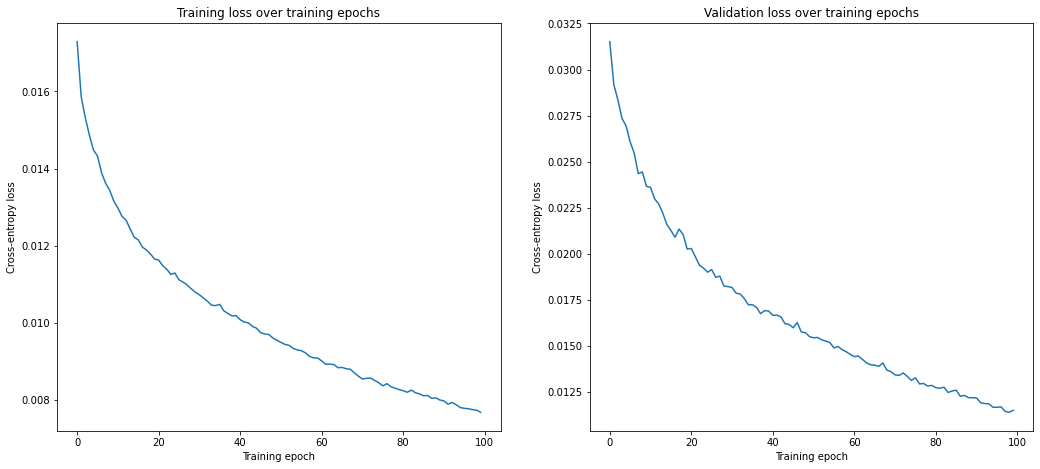

Final Training Epoch: 100, Test Accuracy: 0.58


In [4]:
fig = plt.gcf()
fig.set_size_inches(17.5, 7.5)
plt.subplot(1,2,1)
plt.plot(trn_loss[0:epoch])
plt.title('Training loss over training epochs')
plt.xlabel('Training epoch')
plt.ylabel('Cross-entropy loss')
plt.subplot(1,2,2)
plt.plot(val_loss[0:epoch])
plt.title('Validation loss over training epochs')
plt.xlabel('Training epoch')
plt.ylabel('Cross-entropy loss')
plt.show()

all_tst_true = []
all_tst_pred = []
for batch in tst_dl:
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = batch
    if cuda_status:
        inputs = inputs.to(gpu)
        labels = labels.to(gpu)
    # forward
    outputs = mdl(inputs)
    #loss = criterion(outputs,labels) + reg_term
    loss = criterion(outputs,labels)
    all_tst_true = np.concatenate((all_tst_true,labels.cpu()))
    all_tst_pred = np.concatenate((all_tst_pred,np.argmax(outputs.cpu().detach().numpy(),1)),0)

tst_acc = np.mean(all_tst_true == all_tst_pred)

print('Final Training Epoch: {0}, Test Accuracy: {1:.2f}' \
      .format(epoch, tst_acc))

# Explore operations carried out by the network

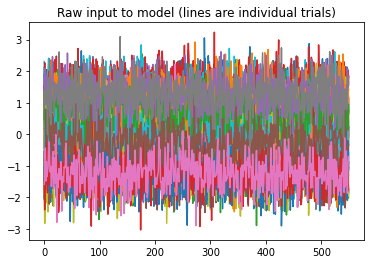

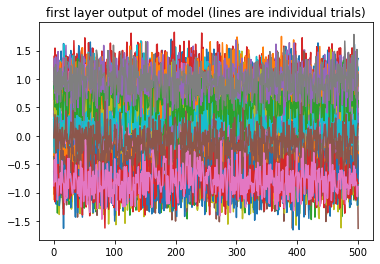

In [5]:
# check out convolutional filter as applied to input data
w = mdl.conv1.weight.data.cpu().detach() # model weights
li = inputs.cpu().detach() # test input to model
channel = 7 # one EEG channel filter to visualize
weight_ind = int(channel*hidden_no/input_chans) # need to convert channel number to convolutional filter index
plt.plot(li[:,channel,].cpu().detach().T)
plt.title('Raw input to model (lines are individual trials)')
plt.show()
x1 = mdl.conv1(inputs) # convolutional transformation applied by model
plt.plot(x1[:,weight_ind,].cpu().detach().T)
plt.title('first layer output of model (lines are individual trials)')
plt.show()

If training was successful, you can see the convolutional operations help sepearte the inputs (hopefully into their respective classes)